In [33]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [34]:
from solution.dicom_utils import *
from solution.plots import *
from solution.dataset import *

In [35]:
from pathlib import *
import pandas as pd

### Part 1: Parse the DICOM images and Contour Files

**How did you verify that you are parsing the contours correctly?**
   
   I've verfied the functions are working by inspecting images and masks on top of images for every patient. The best practice I've learned through Kaggle forums is that if your dataset is small you should check each and every image. This should apply to writing code for parsing, transformations and inference.


**What changes did you make to the code, if any, in order to integrate it into our production code base? **

   I haven't made any changes after seeing and verifying that functions are outputting the expected mask on top of the ROI.Rather I wrote my code on top of already existing code.

### Step by step: How to use solution package for Part 1 

In [36]:
# get path objects
data = list(Path('final_data/').iterdir())

In [37]:
data

[PosixPath('final_data/dicoms'),
 PosixPath('final_data/images'),
 PosixPath('final_data/contourfiles'),
 PosixPath('final_data/link.csv')]

In [38]:
# read link.csv
links = pd.read_csv(data[-1])

# rename dataframe columns for explicity
links = links.rename(columns={'patient_id':'dicoms', 'original_id':'contourfiles'})

# create link pairs of dicom_id anf contourfiles_id
link_pairs = list(zip(links['dicoms'], links['contourfiles']))

In [69]:
link_pairs

[('SCD0000101', 'SC-HF-I-1'),
 ('SCD0000201', 'SC-HF-I-2'),
 ('SCD0000301', 'SC-HF-I-4'),
 ('SCD0000401', 'SC-HF-I-5'),
 ('SCD0000501', 'SC-HF-I-6')]

In [39]:
# initialize Patient objects for each link
patients = []
for dicom_id, contour_id in link_pairs:
    patient = Patient(dicom_id, contour_id, data[0], data[2])
    patients.append(patient)

In [40]:
patients

In [41]:
patients[0].dicom_id, patients[0].contour_id

('SCD0000101', 'SC-HF-I-1')

In [42]:
patients[0].dicoms_path, patients[0].contourfiles_path

(PosixPath('final_data/dicoms'), PosixPath('final_data/contourfiles'))

In [43]:
# save all patients images and contour mask images
# this is for sanity check to see if pipeline is working fine
# after running this you can go and check folders under final_data/images/
save_images(patients, contour_type='i_contour', main_dir='final_data/images/')

# of dicoms : 480, i_contours : 36, o_contours : 18
# of valid dicoms : 240, i_contours : 18, o_contours : 9
# of dicoms : 520, i_contours : 36, o_contours : 18
# of valid dicoms : 260, i_contours : 18, o_contours : 9
# of dicoms : 400, i_contours : 40, o_contours : 20
# of valid dicoms : 200, i_contours : 20, o_contours : 10
# of dicoms : 440, i_contours : 36, o_contours : 18
# of valid dicoms : 220, i_contours : 18, o_contours : 9
# of dicoms : 440, i_contours : 44, o_contours : 18
# of valid dicoms : 220, i_contours : 22, o_contours : 9


In [44]:
# do for o_contour too
save_images(patients, contour_type='o_contour', main_dir='final_data/images/')

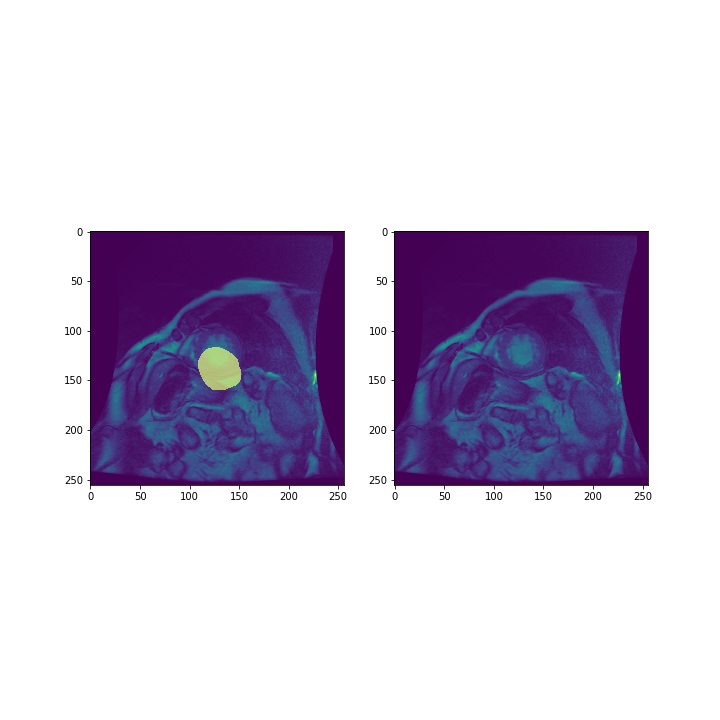

In [45]:
# For example patient 501's masks seems to be shifted
# Of course, I am not an expert but compared to other images it is the case
Image.open('final_data/images/o_contour/SCD0000501/slice_179.png')

### Step by step: How to use solution package for Part 2 

**Did you change anything from the pipelines built in Parts 1 to better streamline the pipeline built in Part 2? If so, what? If not, is there anything that you can imagine changing in the future?**

The main design I've tried to create focuses on Patient. I believe this will enable more flexibility in the future.

The controversial part of this design is that `get_patient_files` function is hard coded for `i-contours` and `o-contours`. If there will be other type of contours or missing contours then this design can fail. But since the instructions mentioned only these two contour types I didn't go further and over complicated the design for more generalizability.

**How do you/did you verify that the pipeline was working correctly?**

Creating dataset and dataloaders depends only on Patient objects. So as long as Patient objects are error-free we can be sure that dataloaders will work fine. Plus we can still visualize them.


**Given the pipeline you have built, can you see any deficiencies that you would change if you had more time? If not, can you think of any improvements/enhancements to the pipeline that you could build in?**

As I've mentioned before hard coding for directories might be one problem, if we have more or different type of contours indicated by different names in the future. Other than that I've written a single dataset for 2D problem but a more general dataset class can be created which can allow `model_type = "2D" or "3D"`. This final point is the main reason why I focused my design on patients by specifying them as objects, in future a 3D dataset can be easily made by still using the same Patient object.

In [70]:
# create pytorch dataset
heart_ds = HeartDataset2D(all_patients = patients, contour_type = 'i_contour')

In [73]:
# number of samples
print(f'number of samples : {len(heart_ds)}')

number of samples : 96


In [74]:
# DICOM - CONTOUR FILE PAIRS
heart_ds.dicom_contour_fnames[:5]

[('final_data/dicoms/SCD0000101/188.dcm',
  'final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0188-icontour-manual.txt'),
 ('final_data/dicoms/SCD0000101/108.dcm',
  'final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0108-icontour-manual.txt'),
 ('final_data/dicoms/SCD0000101/219.dcm',
  'final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0219-icontour-manual.txt'),
 ('final_data/dicoms/SCD0000101/208.dcm',
  'final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0208-icontour-manual.txt'),
 ('final_data/dicoms/SCD0000101/48.dcm',
  'final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0048-icontour-manual.txt')]

In [87]:
# batch size = 8 
# shuffle = True will give us random batches at every epoch - you may visually see it's changing
# just run the following lines multiple times
heart_dl = DataLoader(heart_ds, batch_size=8, shuffle=True)

In [88]:
# number of batches
print(f'Number of batches : {len(heart_dl)}')

Number of batches : 12


In [89]:
x,y = next(iter(heart_dl))

In [90]:
# bs, channel size, H, W 
x.size(), y.size()

(torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256]))

In [91]:
x_np, y_np = x.numpy(), y.numpy()

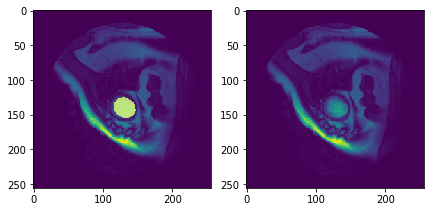

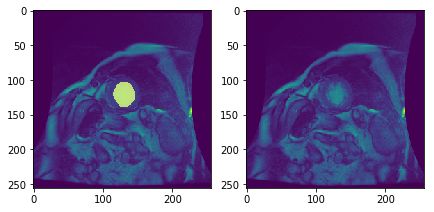

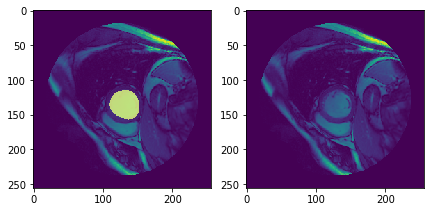

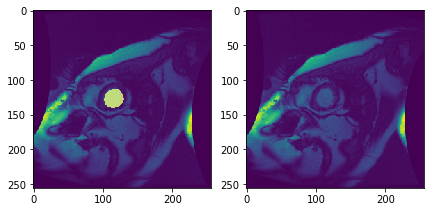

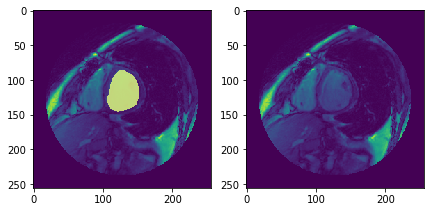

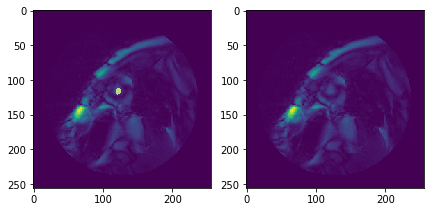

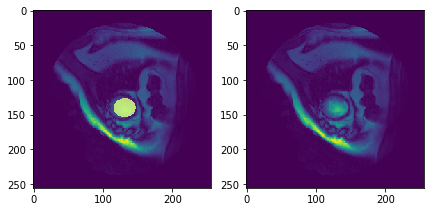

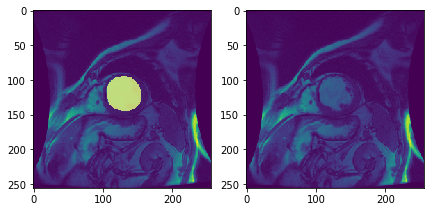

In [92]:
# let's plot a single batch
for img, msk in zip(x_np, y_np):
    show_img_msk_fromarray(img[0], msk[0], cmap='Wistia', alpha=0.8)